# Object Detection: VOC Dataset

## Import dependencies

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Basic Setup

### Use GPU to speed up the tasks

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
if gpus: 
  tf.config.experimental.set_memory_growth(gpus[0], True)

### Load COCO Dataset

In [ ]:
voc, info = tfds.load(
    'voc', 
    split = 'all', 
    with_info = True
)

len(voc), info

(9963,
 tfds.core.DatasetInfo(
     name='voc',
     full_name='voc/2007/4.0.0',
     description="""
     This dataset contains the data from the PASCAL Visual Object Classes Challenge,
     corresponding to the Classification and Detection competitions.
     
     In the Classification competition, the goal is to predict the set of labels
     contained in the image, while in the Detection competition the goal is to
     predict the bounding box and label of each individual object.
     annotations.
     """,
     config_description="""
     This dataset contains the data from the PASCAL Visual Object Classes Challenge
     2007, a.k.a. VOC2007.
     
     A total of 9963 images are included in this dataset, where each image
     contains a set of objects, out of 20 different classes, making a total of
     24640 annotated objects.
     
     """,
     homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
     data_path='/root/tensorflow_datasets/voc/2007/4.0.0',
     file_form

### Define utilities

In [ ]:
VOC_CLASSES = [
    'aeroplane', 
    'bicycle', 
    'bird', 
    'boat', 
    'bottle',
    'bus', 
    'car', 
    'cat', 
    'chair', 
    'cow', 
    'diningtable', 
    'dog', 
    'horse', 
    'motorbike', 
    'person', 
    'pottedplant', 
    'sheep', 
    'sofa', 
    'train', 
    'tvmonitor',
]

In [ ]:
def partition(
    dataset: tf.data.Dataset, train: float = 0.8, test: float = 0.1, val: float = 0.1,
    shuffle: bool = True, shuffle_size: int = 1000, seed: int = 101
) -> tuple:
    assert(train + test + val == 1)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed)

    dataset_size = len(dataset)
    train_size = int(train * dataset_size)
    val_size = int(val * dataset_size)

    dataset_train = dataset.take(train_size)
    dataset_test = dataset.skip(train_size).skip(val_size)
    dataset_val = dataset.skip(train_size).take(val_size)

    return dataset_train, dataset_test, dataset_val

In [ ]:
def preprocess_data(data: dict, image_size: int) -> tuple:
    image = data['image']
    bbox = data['objects']['bbox'][0]
    label = data['objects']['label'][0]
    # resize the image
    image = tf.image.resize(image, (image_size, image_size))    
    # normalize the pixel values
    image = image / 255.0
    # one-hot labels
    label = tf.one_hot(label, depth = 20)
    return image, (label, bbox)

In [ ]:
def pipeline(data: tf.data.Dataset, batch_size: int = 32, image_size: int = 256) -> tf.data.Dataset:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    data = data.map(lambda entry: preprocess_data(entry, image_size), num_parallel_calls = AUTOTUNE)
    data = data.shuffle(len(data))
    data = data.padded_batch(batch_size)
    data = data.prefetch(AUTOTUNE)
    return data

## Process Data

### Partition Datasets

In [ ]:
train, test, val = partition(voc)

### Create Data Pipeline

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

train = pipeline(train, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)
test = pipeline(test, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)
val = pipeline(val, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)

### Look at some train units

In [ ]:
train_units = train.as_numpy_iterator()

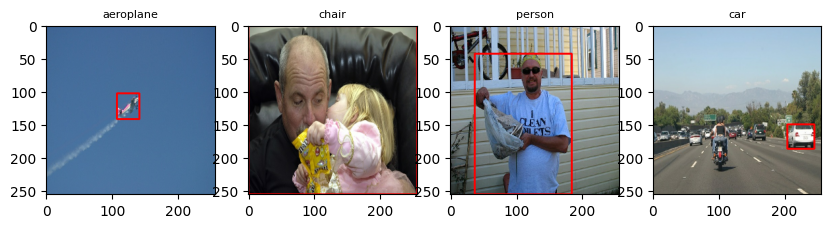

In [ ]:
train_unit = train_units.next()
images, (labels, bboxs) = train_unit

fig, ax = plt.subplots(ncols = 4, figsize = (10, 10))
for i in range(4):
    img = images[i]
    bbox = bboxs[i]
    label = labels[i]
    ax[i].set_title(VOC_CLASSES[np.where(label == 1)[0][0]], fontsize = 8)
    ax[i].imshow(
        cv2.rectangle(
            img,
            (bbox[:2][::-1] * 256).astype(int),
            (bbox[2:][::-1] * 256).astype(int),
            color = (255, 0, 0),
            thickness = 2
        )
    )

## Build Neural Network Model

### Load the pre-trained VGG16 model

In [ ]:
vgg = tf.keras.applications.VGG16(include_top = False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build our model

In [ ]:
def build_model(unfreezing: int = 5): 
    input_layer = tf.keras.layers.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    # base model
    vgg = tf.keras.applications.VGG16(include_top = False)
    # freeze the convolutional base
    for layer in vgg.layers[:-unfreezing]: layer.trainable = False
    vgg = vgg(input_layer)
    # classification: object category model
    f = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    clf_in = tf.keras.layers.Dense(2048, activation = 'relu')(f)
    clf_out = tf.keras.layers.Dense(20, activation = 'softmax')(clf_in)
    # regression: bounding box model
    g = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    reg_in = tf.keras.layers.Dense(2048, activation = 'relu')(g)
    reg_out = tf.keras.layers.Dense(4, activation = 'sigmoid')(reg_in)
    return tf.keras.Model(inputs = input_layer, outputs = (clf_out, reg_out))

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

## Define Optimizer and Loss Functions

### Create Optimizer

In [ ]:
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

### Define Losses

In [ ]:
def localization_loss(y, y_hat):            
    delta_coord = tf.reduce_sum(tf.square(y[:, :2] - y_hat[:, :2]))
    delta_size = tf.reduce_sum(
        tf.square((y[:, 3] - y[:, 1]) - (y_hat[:, 3] - y_hat[:, 1])) + 
        tf.square((y[:, 2] - y[:, 0]) - (y_hat[:, 2] - y_hat[:, 0]))
    )    
    return delta_coord + delta_size

In [ ]:
clf_loss = tf.keras.losses.CategoricalCrossentropy()
reg_loss = localization_loss

## Define Custom Object Detection Model

In [ ]:
class ObjectDetector(tf.keras.Model):

    def __init__(self, model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.model = model

    def compile(self, optimizer, clf_loss, reg_loss, **kwargs):
        super().compile(**kwargs)
        self.clf_loss = clf_loss
        self.reg_loss = reg_loss
        self.optimizer = optimizer

    def train_step(self, batch, **kwargs):
        x, y = batch
        with tf.GradientTape() as tape:
            y_hat = self.model(x, training = True)
            batch_clf_loss, batch_reg_loss = self.get_losses(y, y_hat)
            total_loss = 0.5*batch_clf_loss + batch_reg_loss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grad, self.model.trainable_variables)
        )
        return {
            'total_loss' : total_loss, 
            'batch_clf_loss' : batch_clf_loss, 
            'batch_reg_loss' : batch_reg_loss
        }

    def test_step(self, batch, **kwargs):
        x, y = batch
        y_hat = self.model(x, training = False)
        batch_clf_loss, batch_reg_loss = self.get_losses(y, y_hat)
        total_loss = 0.5*batch_clf_loss + batch_reg_loss
        return {
            'total_loss' : total_loss, 
            'batch_clf_loss' : batch_clf_loss, 
            'batch_reg_loss' : batch_reg_loss
        }

    def get_losses(self, y, y_hat):
        return self.clf_loss(y[0], y_hat[0]), self.reg_loss(y[1], y_hat[1])

    def call(self, x, **kwargs):
        return self.model(x, **kwargs)

## Train the Neural Network

In [ ]:
model = build_model()

object_detector = ObjectDetector(model)
object_detector.compile(optimizer, clf_loss, reg_loss)

In [ ]:
history = object_detector.fit(
    train,
    epochs = 15, 
    batch_size = BATCH_SIZE, 
    validation_data = val, 
    verbose = 2, 
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir = 'logs')]
)

Epoch 1/15
250/250 - 36s - total_loss: 1.4758 - batch_clf_loss: 2.2004 - batch_reg_loss: 0.3756 - val_total_loss: 0.8129 - val_batch_clf_loss: 1.0553 - val_batch_reg_loss: 0.2852 - 36s/epoch - 142ms/step
Epoch 2/15
250/250 - 27s - total_loss: 0.7038 - batch_clf_loss: 1.0712 - batch_reg_loss: 0.1683 - val_total_loss: 1.5384 - val_batch_clf_loss: 2.2080 - val_batch_reg_loss: 0.4344 - 27s/epoch - 107ms/step
Epoch 3/15
250/250 - 25s - total_loss: 0.6230 - batch_clf_loss: 1.0798 - batch_reg_loss: 0.0831 - val_total_loss: 0.5737 - val_batch_clf_loss: 0.4578 - val_batch_reg_loss: 0.3448 - 25s/epoch - 101ms/step
Epoch 4/15
250/250 - 25s - total_loss: 0.3940 - batch_clf_loss: 0.1594 - batch_reg_loss: 0.3143 - val_total_loss: 0.5100 - val_batch_clf_loss: 0.7167 - val_batch_reg_loss: 0.1516 - 25s/epoch - 101ms/step
Epoch 5/15
250/250 - 25s - total_loss: 0.1020 - batch_clf_loss: 0.0665 - batch_reg_loss: 0.0688 - val_total_loss: 0.1964 - val_batch_clf_loss: 0.2557 - val_batch_reg_loss: 0.0686 - 25s

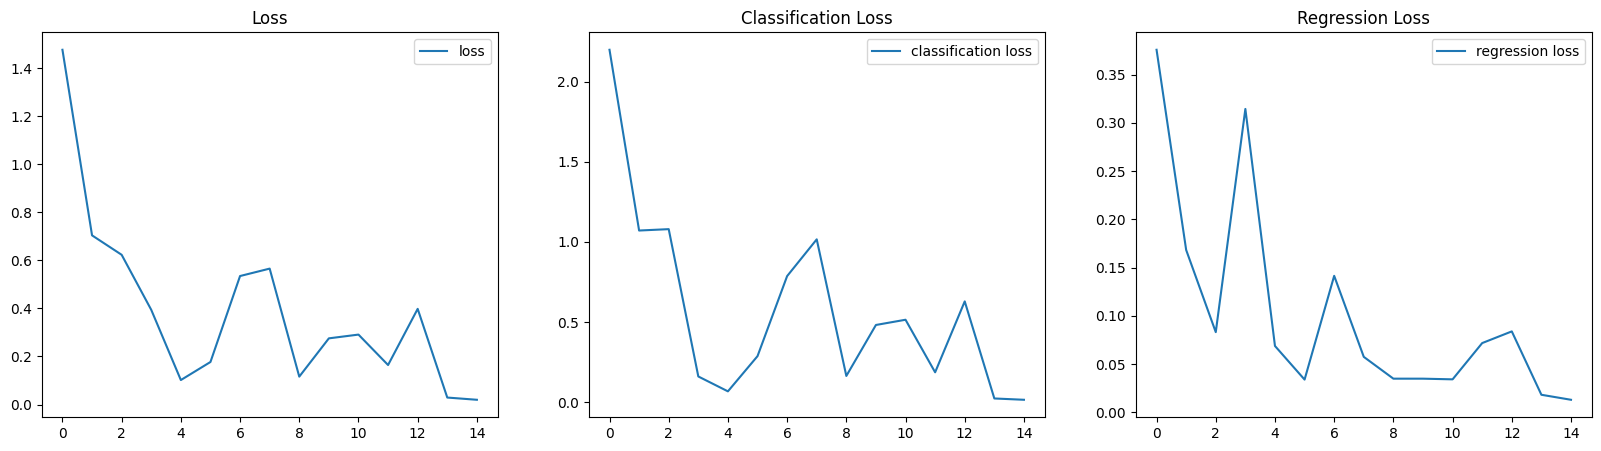

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))

pairs = [
    ('total_loss', 'loss'), 
    ('batch_clf_loss', 'classification loss'), 
    ('batch_reg_loss', 'regression loss')
]

for i, pair in enumerate(pairs):
  key, label = pair
  ax[i].plot(history.history[key], label = label)
  ax[i].title.set_text(label.title())
  ax[i].legend()

plt.show()

## Make Predictions on Test Dataset

### Look at some test units

In [ ]:
test_units = test.as_numpy_iterator()

In [ ]:
test_unit = test_units.next()

1/1 [==============================] - 0s 35ms/step


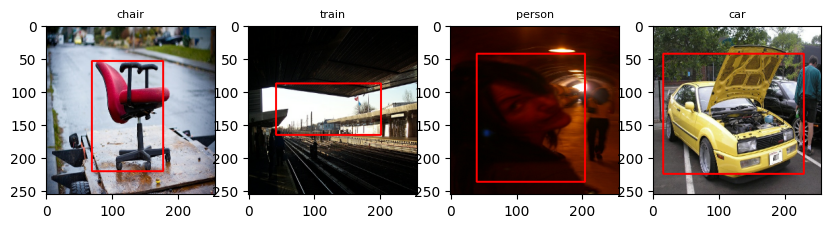

In [ ]:
images, _ = test_unit

labels, bboxs = object_detector.predict(images)

fig, ax = plt.subplots(ncols = 4, figsize = (10, 10))
for i in range(4):
    image = images[i]
    bbox = bboxs[i]
    label = np.argmax(labels[i])
    if label > 0.9:
      ax[i].set_title(VOC_CLASSES[label], fontsize = 8)
      ax[i].imshow(
          cv2.rectangle(
              image,
              (bbox[:2][::-1] * 256).astype(int),
              (bbox[2:][::-1] * 256).astype(int),
              color = (255, 0, 0),
              thickness = 2
          )
      )

### Evaluate the model

In [ ]:
results = object_detector.evaluate(test, verbose = 0)
results

[0.9900863766670227, 0.18123632669448853, 0.6762795448303223]

## Save the model

In [ ]:
model.save("object_detection_model.h5")